# Grouping similar movies and actors using Clustering

In [ ]:
# install networkx and stellargraph
!pip install networkx==2.3
!pip install stellargraph

# import nocessary libraries
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from google.colab import drive
drive.mount('/content/drive/')
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

In [ ]:
# read the data to a dataframe
data=pd.read_csv('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 14/movie_actor_network.csv', index_col=False, names=['movie','actor'])

# create list of edges
edges = [tuple(x) for x in data.values.tolist()]

# create a graph with movie and actor nodes and edges from the data imported
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

# get connected components of the graph to a list
A = list(B.subgraph(c) for c in nx.connected_components(B))[0]

In [ ]:
# do random walk of lenght 100 for all the nodes
rw = UniformRandomMetaPathWalk(StellarGraph(A))
metapaths = [ ["movie", "actor", "movie"],
              ["actor", "movie", "actor"] ]
walks = rw.run(nodes=list(A.nodes()),
               length=100,
               n=1,
               metapaths=metapaths )
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [ ]:
# create word2vec model to featurize the data
model = Word2Vec(walks, size=128, window=5)

# generate 128 dimensional vector, get the node id's, vectors and the target classes (actor/movie)
node_ids = model.wv.index2word
node_embeddings = model.wv.vectors
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

In [ ]:
# split the nodes and featurized vectors for actors and movies
def data_split(node_ids,node_targets,node_embeddings):
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # run loop for all the nodes, including both actor and movie nodes
    for i in range(len(node_ids)):
      # get all the actor nodes and vectors
      if 'a' in node_ids[i]:
        actor_nodes.append(node_ids[i])
        actor_embeddings.append(node_embeddings[i])
      # get all the movie nodes and vectors
      elif 'm' in node_ids[i]:
        movie_nodes.append(node_ids[i])
        movie_embeddings.append(node_embeddings[i])
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

# run the function with the 128 dimensional vectors of all the nodes (nodes for the random walks started with)
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

Calculating cost1

In [ ]:
# function to calculate cost 1
def cost1(graph,number_of_clusters):
  cost_1 = 0
  # initialize, fit and get prediction from the clustering model with 128 dim vectors of all the nodes
  clustering_model = KMeans(n_clusters=number_of_clusters, random_state=15)
  clustering_model.fit(node_embeddings)
  pred = clustering_model.predict(node_embeddings)
  # run the loop for each of the cluster numbers
  for clst_itr in range(0,number_of_clusters):
    # get indices for all the cluster points
    cluster_points_idx = [j for j,i in enumerate(pred) if i == clst_itr]
    # get nodes for all the points in the cluster
    cluster_points = [node_ids[k] for k in cluster_points_idx]
    # create subgraph for each of the clusters
    cluster_graph = graph.subgraph(cluster_points)
    # get connected components in the descending order for all the clusters
    connected_lst = sorted(nx.connected_components(cluster_graph), key=len, reverse=True)
    # get length of the largest connected component if there it exist
    if len(connected_lst) > 0:
      connected_comp = graph.subgraph(connected_lst[0])
      # calculate cost if the connected component is of an actor node
      if len([i for i in connected_comp if 'a' in i]) > 0:
        cost_1 += (connected_comp.number_of_nodes() / graph.number_of_nodes())
        #cost_1 += (connected_comp.number_of_nodes() / cluster_graph.number_of_nodes())
  return (cost_1 / number_of_clusters)

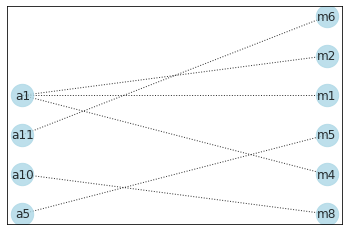

In [ ]:
# create graded graph to test the splitting of data and cost functions
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])

# draw plot for graded graph by matplotlib
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

Calculating cost2

In [ ]:
# function to calculate cost 2
def cost2(graph,number_of_clusters):
  cost_2 = 0
  # initialize, fit and get prediction from the clustering model with 128 dim vectors of all the nodes
  clustering_model = KMeans(n_clusters=number_of_clusters, random_state=15)
  clustering_model.fit(node_embeddings)
  pred = clustering_model.predict(node_embeddings)
  # run the loop for each of the cluster numbers
  for clst_itr in range(0,number_of_clusters):
    # get indices for all the cluster points
    cluster_points_idx = [j for j,i in enumerate(pred) if i == clst_itr]
    # get nodes for all the points in the cluster
    cluster_points = [node_ids[k] for k in cluster_points_idx]
    # create subgraph for each of the clusters
    cluster_graph = graph.subgraph(cluster_points)
    # get degrees for each of the nodes in the graph
    graph_degrees = {node:val for (node, val) in graph.degree()}
    # get the count of edges for the actor nodes in the cluster graph
    edge_count = sum([graph_degrees.get(i) for i in cluster_graph if (i in graph.nodes) and ('a' in i)])
    # find number unique movie nodes in the graph
    unique_m_nodes = len(set(i for i in graph if 'm' in i))
    #unique_m_nodes = len(set(i for i in cluster_graph.nodes if 'm' in i))
    # calculate cost 2 if there are any movie nodes in the cluster graph
    if unique_m_nodes != 0:
      cost_2 += (edge_count / unique_m_nodes)

  return cost_2/number_of_clusters

Grouping similar actors

In [ ]:
# initialize the list of cluster numbers
clusters = [3, 5, 10, 30, 50, 100, 200, 500]
cluster_scores = []
# run loop for all the cluster points and find cost
for i in clusters:
  cluster_scores.append(cost1(B,i) * cost2(B,i))
# get the cluster number for the cluster having highest cost
number_of_clusters = clusters[cluster_scores.index(max(cluster_scores))]
# fit the clustering model with the best cluster number and get predction
clustering_model = KMeans(n_clusters=number_of_clusters, random_state=15)
clustering_model.fit(node_embeddings)
pred = clustering_model.predict(node_embeddings)

Displaying similar actor clusters

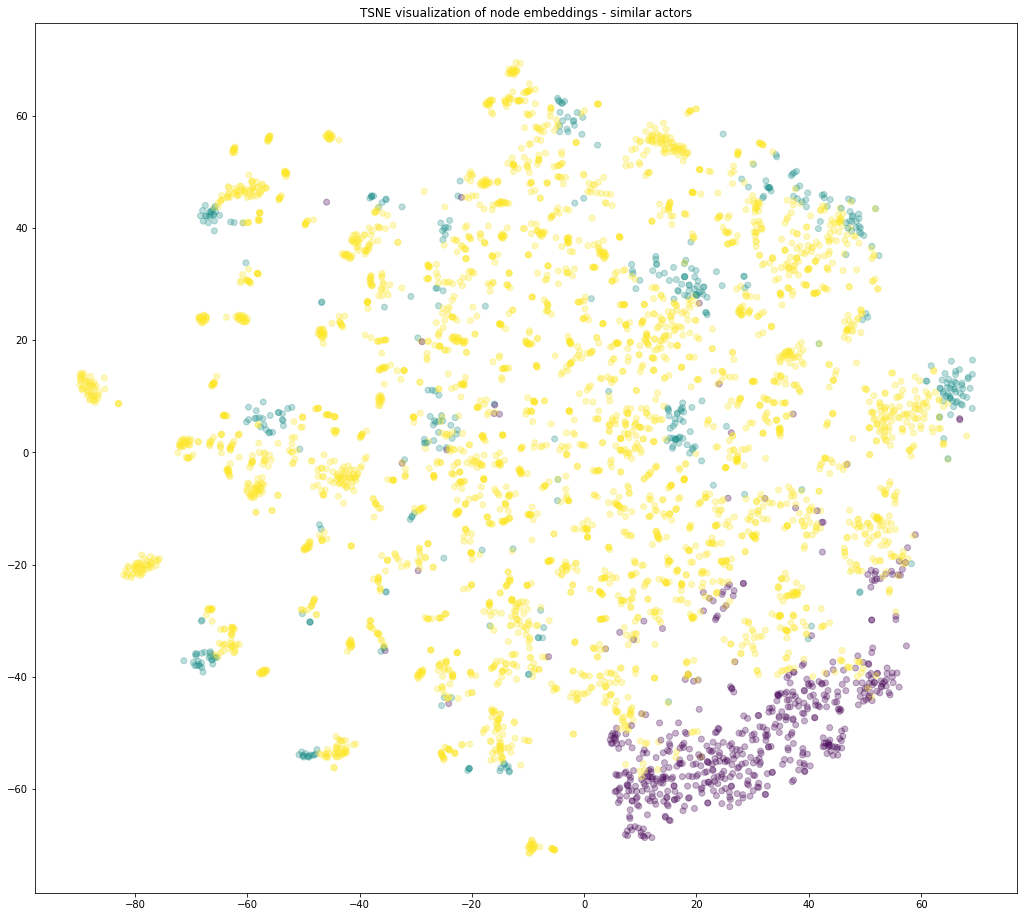

In [ ]:
# initialize, fit and transform TSNE model to get 2 dimensional vectors for the 128 dimensional vectors created by random walking on all the nodes
TSNE_model = TSNE
dim_reduce_model = TSNE_model(n_components=2)
node_embeddings_2d = dim_reduce_model.fit_transform(node_embeddings)
# plot graph with colors defined by the cluster number getting from clustering model predictions
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = pred
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1], c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings - similar actors'.format(TSNE_model.__name__))
plt.show()

Apply clustering algorithm to group similar movies

Calculating cost1

In [ ]:
# function to calculate cost 1
def cost1(graph,number_of_clusters):
  cost_1 = 0
  # initialize, fit and get prediction from the clustering model with 128 dim vectors of all the nodes
  clustering_model = KMeans(n_clusters=number_of_clusters, random_state=15)
  clustering_model.fit(node_embeddings)
  pred = clustering_model.predict(node_embeddings)
  # run the loop for each of the cluster numbers
  for clst_itr in range(0,number_of_clusters):
    # get indices for all the cluster points
    cluster_points_idx = [j for j,i in enumerate(pred) if i == clst_itr]
    # get nodes for all the points in the cluster
    cluster_points = [node_ids[k] for k in cluster_points_idx]
    # create subgraph for each of the clusters
    cluster_graph = graph.subgraph(cluster_points)
    # get connected components in the descending order for all the clusters
    connected_lst = sorted(nx.connected_components(cluster_graph), key=len, reverse=True)
    # get length of the largest connected component if there it exist
    if len(connected_lst) > 0:
      connected_comp = graph.subgraph(connected_lst[0])
      # calculate cost if the connected component is of a movie node
      if len([i for i in connected_comp if 'm' in i]) > 0:
        cost_1 += (connected_comp.number_of_nodes() / graph.number_of_nodes())
        #cost_1 += (connected_comp.number_of_nodes() / cluster_graph.number_of_nodes())
  return (cost_1 / number_of_clusters)

Calculating cost2

In [ ]:
# function to calculate cost 2
def cost2(graph,number_of_clusters):
  cost_2 = 0
  # initialize, fit and get prediction from the clustering model with 128 dim vectors of all the nodes
  clustering_model = KMeans(n_clusters=number_of_clusters, random_state=15)
  clustering_model.fit(node_embeddings)
  pred = clustering_model.predict(node_embeddings)
  # run the loop for each of the cluster numbers
  for clst_itr in range(0,number_of_clusters):
    # get indices for all the cluster points
    cluster_points_idx = [j for j,i in enumerate(pred) if i == clst_itr]
    # get nodes for all the points in the cluster
    cluster_points = [node_ids[k] for k in cluster_points_idx]
    # create subgraph for each of the clusters
    cluster_graph = graph.subgraph(cluster_points)
    # get degrees for each of the nodes in the graph
    graph_degrees = {node:val for (node, val) in graph.degree()}
    # get the count of edges for the movie nodes in the cluster graph
    edge_count = sum([graph_degrees.get(i) for i in cluster_graph if (i in graph.nodes) and ('m' in i)])
    # find number unique actor nodes in the graph
    unique_a_nodes = len(set(i for i in graph if 'a' in i))
    #unique_a_nodes = len(set(i for i in cluster_graph.nodes if 'a' in i))
    # calculate cost 2 if there are any actor nodes in the cluster graph
    if unique_a_nodes != 0:
      cost_2 += (edge_count / unique_a_nodes)

  return cost_2/number_of_clusters

Grouping similar movies

In [ ]:
# initialize the list of cluster numbers
clusters = [3, 5, 10, 30, 50, 100, 200, 500]
cluster_scores = []
# run loop for all the cluster points and find cost
for i in clusters:
  cluster_scores.append(cost1(B,i) * cost2(B,i))
# get the cluster number for the cluster having highest cost
number_of_clusters = clusters[cluster_scores.index(max(cluster_scores))]
# fit the clustering model with the best cluster number and get predction
clustering_model = KMeans(n_clusters=number_of_clusters, random_state=15)
clustering_model.fit(node_embeddings)
pred = clustering_model.predict(node_embeddings)

Displaying similar movie clusters

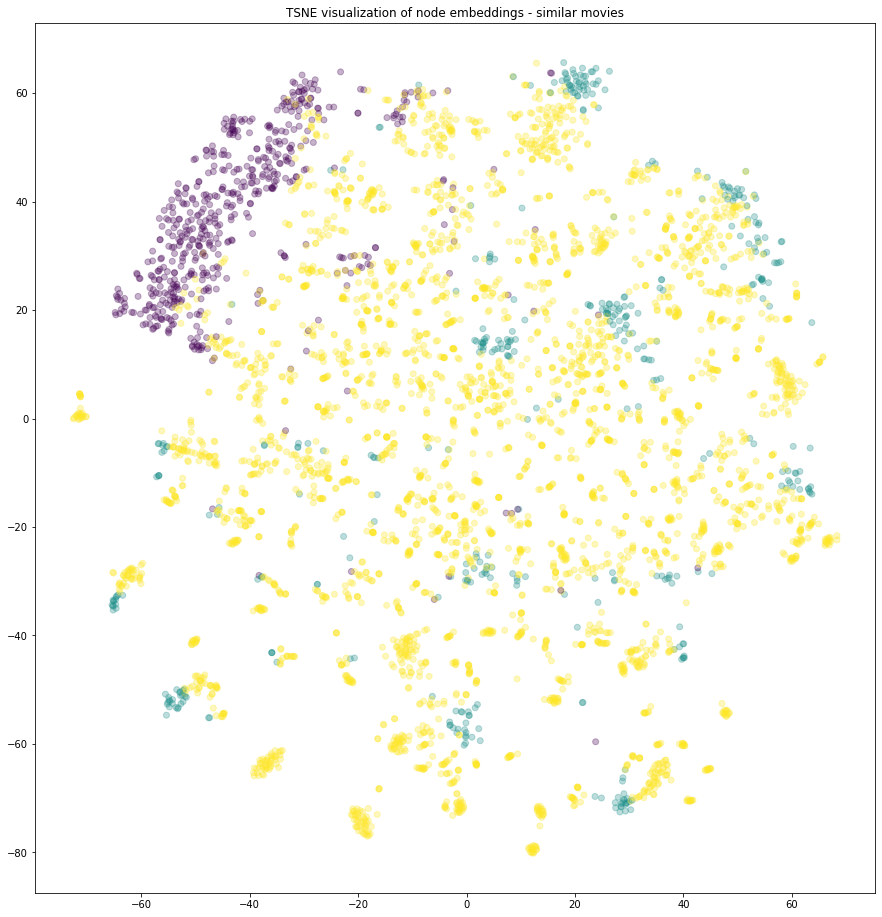

In [ ]:
# initialize, fit and transform TSNE model to get 2 dimensional vectors for the 128 dimensional vectors created by random walking on all the nodes
TSNE_model = TSNE
dim_reduce_model = TSNE_model(n_components=2)
node_embeddings_2d = dim_reduce_model.fit_transform(node_embeddings)
# plot graph with colors defined by the cluster number getting from clustering model predictions
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = pred
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1], c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings - similar movies'.format(TSNE_model.__name__))
plt.show()